# Notebook 02: Temperature Dependency of Acetogenic Yield 

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

# Temperature Dependence of Acetogenesis Yield 

This notebook creates a thermodynamic-based black-box model of acetogenic growth and deduces various consumption, production, and growth yields as a fonction of temperature.

Notebook author: Philip J. Gorter de Vries

In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.optimize import curve_fit

# Define Process Parameters

In [2]:
R = 8.314 # [m^3*Pa/K/mol]

#Temperature range:
T0 = 273.15
dt = 80
T = np.arange(T0, T0+dt+1, 1)

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

# Deduce Acetogenic Yields

Acetogenic yields can be deduced from the overall reaction stoichiometries, which can be divided in two sub-rection: the anabolic reaction producing biomass from these substrates (eq. 21 & 22), and the catabolic reaction, releasing energy by production of acetate(eq. 19 & 20). Only acetate is considered as a product, and both carboxydotrophic and homoacetogenic growth are included.

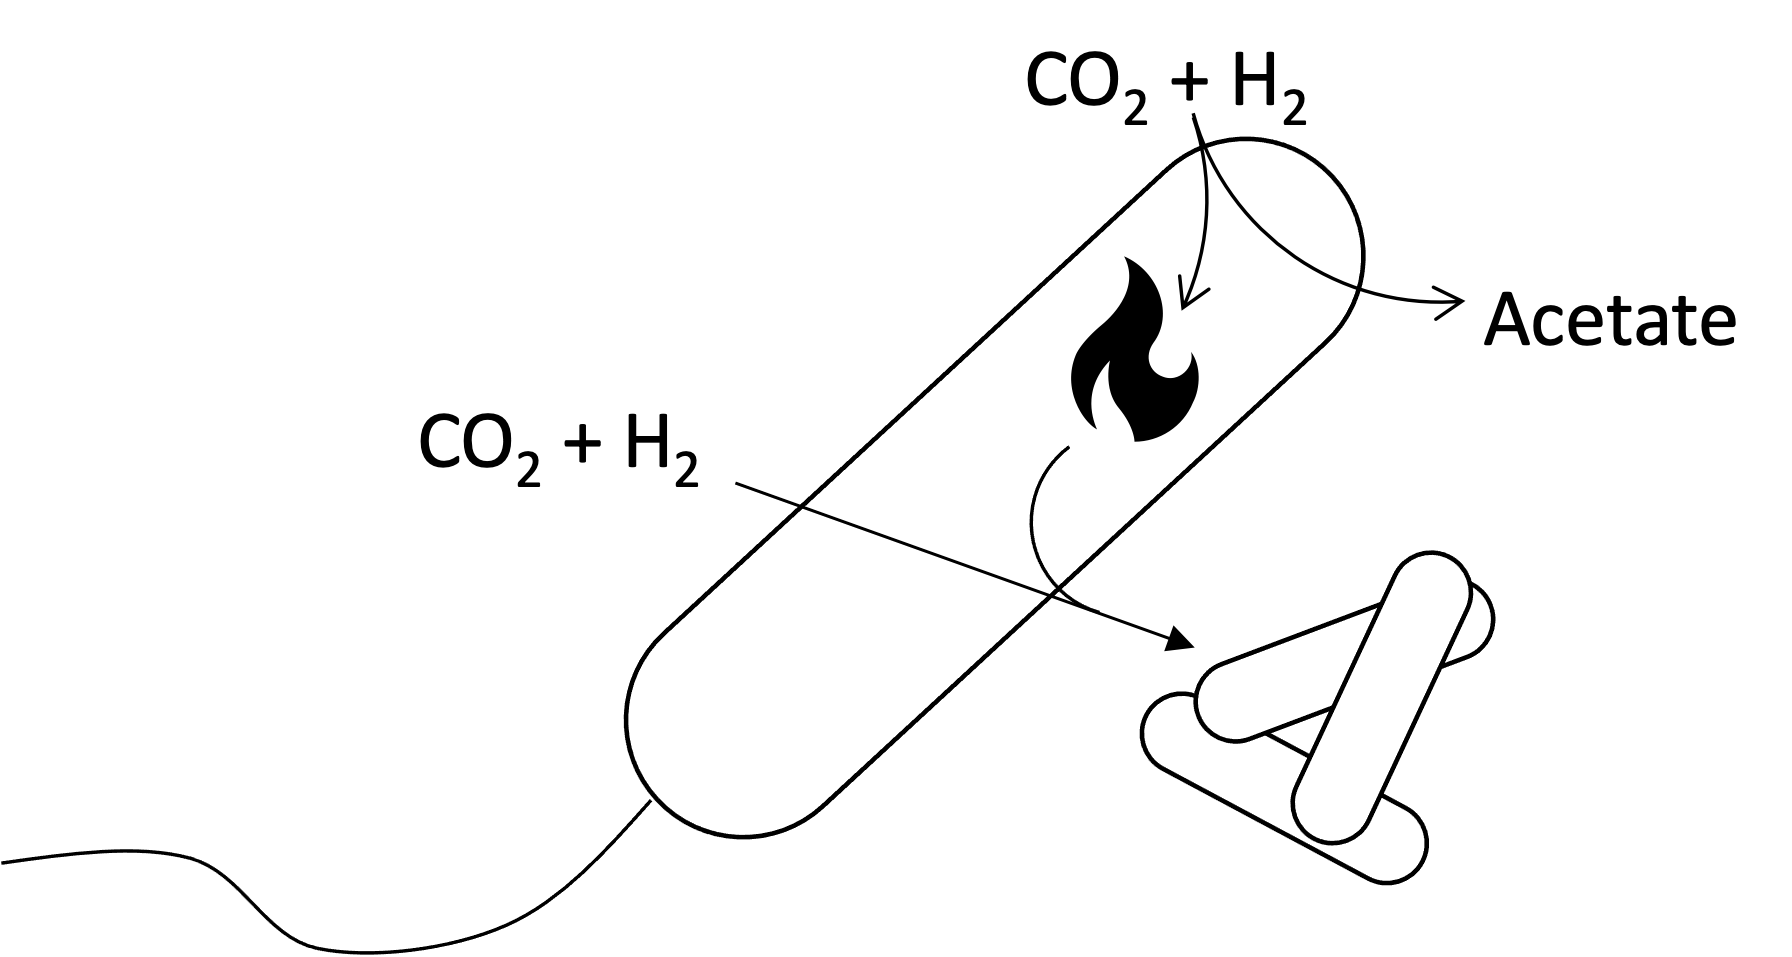

In [3]:
Image(filename='../Figures/ThermodynamicModelAnaCata.png', width = 500)

<p>Catabolic reaction stoichiometries </p>

<p>$ 2 CO_2 + 4 H_2 <=> CH_3COOH + 2 H_2O $ 
    <span style="float:right;">(eq. 19)</span> </p>
<p>$ 4 CO + 2 H_2O <=> CH_3COOH + 2 CO_2 $
    <span style="float:right;">(eq. 20)</span> </p>

<p>Anabolic reaction stoichiometries:</p>

<p>$ CO_2 + 2.1 H_2 + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O$
    <span style="float:right;">(eq. 21)</span>  </p>
<p>$ 2.1 CO + 0.6 H_2O + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2$
    <span style="float:right;">(eq. 22)</span> </p>
    
The reaction's stoichiometries can be summarized in a DataFrame S

<p> For comparisson methanogens are included:</p>
<p>$ CO_2 + 4 H_2 <=> CH_4 + 2 H_2O $ 
    <span style="float:right;">(eq. 19)</span> </p>
<p>$ 4 CO + 2 H_2O <=> CH_4 + 3 CO_2 $
    <span style="float:right;">(eq. 20)</span> </p>

In [38]:
S = pd.DataFrame({
    'HomCata':     [0,    -4,  0,    -2,   2,    0,  1, 0],
    'CarbCata':    [-4,   0,   0,    2,    -2,   0,  1, 0],
    'HomAna':      [0,   -2.1, -0.2, -1,   1.5,  1,  0, 0],
    'CarbAna':     [-2.1, 0,   -0.2, 1.1,  -0.6, 1,  0, 0],
    'HomMetCata':  [0,    -4,  0,    -1,   2,    0,  0, 1],
    'CarbMetCata':    [-4,   0,   0,    3,    -2,   0,  0, 1]},
    index=pd.Index(["CO","H2","NH3","CO2","Water","X","Acetate","Methane"]))

S

,HomCata,CarbCata,HomAna,CarbAna,HomMetCata,CarbMetCata
CO,0,-4,0.0,-2.1,0,-4
H2,-4,0,-2.1,0.0,-4,0
NH3,0,0,-0.2,-0.2,0,0
CO2,-2,2,-1.0,1.1,-1,3
Water,2,-2,1.5,-0.6,2,-2
X,0,0,1.0,1.0,0,0
Acetate,1,1,0.0,0.0,0,0
Methane,0,0,0.0,0.0,1,1


# Calculate Gibbs Free Energy and Enthalpy of Reaction

With the anabolic and catabolic reactions determined, the next step is to add them up to find the overall reaction stoichiometry. For this purpose, a factor needs to be found to multiply the catabolic reaction by, to balance out the energy produced by catabolism with the energy required for anabolism. Firstly, the energy generated by the catabolic reaction is expressed as a function of temperature, using the Gibbs-Helmoltz equation (eq. 26) for both carboxydotrophic and homoacetogenic growth.

<p>Gibbs free energy of reaction: </p>
<div style="text-align: center">  $ \Delta _r G^0 = \sum_i v_i * \Delta _fG_i^0$ [$kJ/mol$]
    <span style="float:right;">(eq. 24)</span>
</div>

<p>Reaction enthalpy: </p>
<div style="text-align: center">  $ \Delta _r H^0 = \sum_i v_i * \Delta _fH_i^0$ [$kJ/mol$]
    <span style="float:right;">(eq. 25)</span>
</div>

<p>Gibbs-Helmoltz equation: </p>
<div style="text-align: center">  $ \Delta _r G^T = \Delta _r G^0*(T/298.15) +\Delta _r H^0 * (1-T/298.15) $ [$kJ/mol$]
    <span style="float:right;">(eq. 26)</span>
</div>

Gibbs energy of reaction at standard temperature:
  DrGR_carb = -231.2 [kJ/mol]
  DrGR_hom = -152.5 [kJ/mol]
  DrGR_carbM = -263.4 [kJ/mol]
  DrGR_homM = -184.8 [kJ/mol]

Enthalpy of reaction at standard temperature:
  DrHR_carb = -217.3 [kJ/mol]
  DrHR_hom = -253.6 [kJ/mol]
  DrHR_carbM = -214.0 [kJ/mol]
  DrHR_homM = -250.4 [kJ/mol]



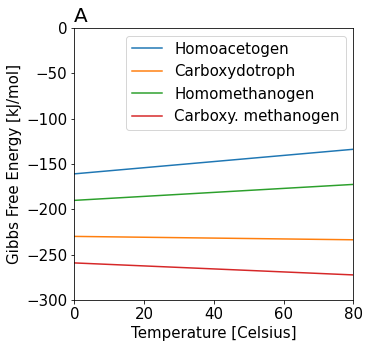

In [50]:
# Load the thermodynamic data of the compounds
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"dfGR": float, "dfGR": float})["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"dfGR": float, "dfGR": float})["dfHR"]

# Calculate the Gibbs free energy of reaction from the reaction stoichiometry and Gibbs free energy of formation (eq.24)
DrGR_carb = np.nansum(S.CarbCata * dfGR)
DrGR_hom = np.nansum(S.HomCata * dfGR)
DrGR_carbM = np.nansum(S.CarbMetCata * dfGR)
DrGR_homM = np.nansum(S.HomMetCata * dfGR)

print("Gibbs energy of reaction at standard temperature:\n",
      " DrGR_carb =",round(DrGR_carb,1),"[kJ/mol]\n",
      " DrGR_hom =",round(DrGR_hom,1),"[kJ/mol]\n",
      " DrGR_carbM =",round(DrGR_carbM,1),"[kJ/mol]\n",
      " DrGR_homM =",round(DrGR_homM,1),"[kJ/mol]\n")

# Calculate the Enthalpy of reaction from the reaction stoichiometry and Enthalpy of the compounds (eq.25)
DrHR_carb = np.nansum(S.CarbCata * dfHR)
DrHR_hom = np.nansum(S.HomCata * dfHR)
DrHR_carbM = np.nansum(S.CarbMetCata * dfHR)
DrHR_homM = np.nansum(S.HomMetCata * dfHR)

print("Enthalpy of reaction at standard temperature:\n",
      " DrHR_carb =", round(DrHR_carb,1),"[kJ/mol]\n",
      " DrHR_hom =", round(DrHR_hom,1),"[kJ/mol]\n",
      " DrHR_carbM =",round(DrHR_carbM,1),"[kJ/mol]\n",
      " DrHR_homM =",round(DrHR_homM,1),"[kJ/mol]\n")

#Gibbs–Helmholtz equation for temperature correction (eq.26)
def DrGT_carb(T):
    return DrGR_carb * (T/298.15) + DrHR_carb * (1-T/298.15)
def DrGT_hom(T):
    return DrGR_hom * (T/298.15) + DrHR_hom * (1-T/298.15)
def DrGT_carbM(T):
    return DrGR_carbM * (T/298.15) + DrHR_carbM * (1-T/298.15)
def DrGT_homM(T):
    return DrGR_homM * (T/298.15) + DrHR_homM * (1-T/298.15)

plt.figure(figsize=(5,5))
#plt.title(f"Gibbs Free Energy of Acetogenesis and Methanogenesis")
plt.title("A", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 80, -300, 0])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Gibbs Free Energy [kJ/mol]', fontsize=15)
plt.plot(Kelvin_Celsius(T), DrGT_hom(T))
plt.plot(Kelvin_Celsius(T), DrGT_carb(T))
plt.plot(Kelvin_Celsius(T), DrGT_homM(T))
plt.plot(Kelvin_Celsius(T), DrGT_carbM(T))
plt.legend(['Homoacetogen','Carboxydotroph','Homomethanogen','Carboxy. methanogen'], fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

# Calculate Maintenance Energy Requirements

The maintenance energy requirement is key to determine the amount of substrate needed that will not be funneled to the product. Maintenance energy requirements can be divided into growth-associated (GAM) or non-growth associated maintenance (NGAM).

## Non-Growth-Associated Maintenance

For GAM a temperature correlation has been found. Based on a wide range of studied anaerobic organisms, NGAM can be estimated through the temperature-dependent expression based on the Arrhenius expression, as proposed by Tijhuis et al. (eq. 23), an approximation for ($m_{g}$) also used by Redl et al., 2017..

<p> NGAM: </p>
<div style="text-align: center">  $ m_{NGAM} = 3.3^{6900/R*(1/298-1/T)} $ [$kJ/h/Cmol_{biomass}$]
    <span style="float:right;">(eq. 23)</span>
</div>

\[REF]: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

In [5]:
def m_NGAM(T):
    """
    This function is the Arrhenius equation, as fit by Tijsen et al.
    """
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

print("m_NGAM(300) =", round(m_NGAM(300),2), "[kJ/h/CmolX]")

m_NGAM(300) = 1.25 [kJ/h/CmolX]


For comparison, the same data will be fit again using scipy

In [6]:
# load data saved as csv, mostly from Thijhuis et al. DOI: 10.3389/fmicb.2015.01275
m_Anaerobes = pd.read_csv("../Data/m_Anaerobes.csv", encoding= 'unicode_escape', index_col="Species", dtype = {"Topt": float, "µ_max": float,"ToptK": float})

def Arrhenius(T, A, B):
    """
    This function is the Arrhenius equation, as a function of temperature (T), with given constants A and B
    """
    return A * T * np.exp(-B/(R*T))
    
mE_popt, mE_pcov = curve_fit(Arrhenius, m_Anaerobes.drop("Acetogenium kivui").ToptK, m_Anaerobes.drop("Acetogenium kivui").mE)

#Acetogen kivui is an outlier, when included the model can't find a fit

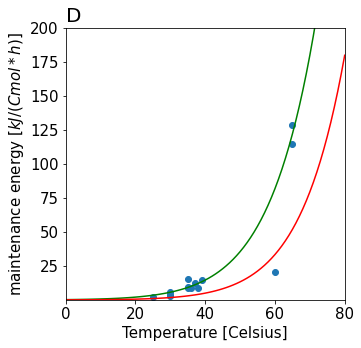

In [7]:
plt.figure(figsize=(5,5))
plt.title(f"D", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 80, 0.1, 200])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel(r'maintenance energy [$kJ/(Cmol*h)$]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Arrhenius(T, *mE_popt), 'g-', label='fit')
plt.plot(Kelvin_Celsius(T), m_NGAM(T), 'r-', label='fit')
plt.scatter(Kelvin_Celsius(m_Anaerobes.ToptK), m_Anaerobes.mE)
#plt.yscale('log')

plt.show()

## Growth-Associated Maintenance

GAM can be assumed to be 1000 kJ/Cmol of biomass. While it is not thought to be dependent on temperature, it can only be related to NGAM by multiplying it by the growth rate. Similarly to NGAM, µmax of organisms at their temperature optima seems to follow the Arrhenius equation. Maximum growth rates of known acetogens have thus been plotted by temperature and an Arrhenius equation was fit to the data. 

<p> The Arrhenius equation for max growth rate:</p>
<div style="text-align: center">  $ µ_{max} = A*T*e^{-B/(R*T)} $ [$h^{-1}$]
    <span style="float:right;">(eq. 27)</span>
</div>

/[REF] Heijnen J.J. (2010) Impact of Thermodynamic Principles in Systems Biology. In: Wittmann C., Krull R. (eds) Biosystems Engineering II. Advances in Biochemical Engineering / Biotechnology, vol 121. Springer, Berlin, Heidelberg. https://doi.org/10.1007/10_2009_63

A = 8.664637604856871, B = 24166.931701462072


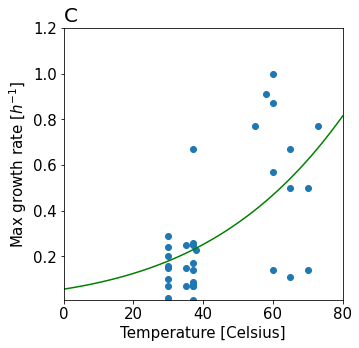

In [9]:
m_GAM = 1000 #kJ/CmolX
print("m_GAM =", m_GAM, "[kJ/CmolX]")

# load data saved as csv, mostly from DOI: 10.3389/fmicb.2015.01275
µ_Acetogens = pd.read_csv("../Data/µ_Acetogens.csv", encoding= 'unicode_escape', index_col="Species", dtype = {"Topt": float, "mu_max": float, "ToptK": float})

# Fit data to Arrhenius equation
popt, pcov = curve_fit(Arrhenius, µ_Acetogens.ToptK, µ_Acetogens.mu_max)

print(f"A = {popt[0]}, B = {popt[1]}")

plt.figure(figsize=(5,5))
plt.title(f"C", fontdict = {'fontsize': 20}, loc = "left")
plt.axis([0, 80, 0.01, 1.2])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel(r'Max growth rate [$h^{-1}$]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Arrhenius(T, *popt), 'g-', label='fit')
plt.scatter(Kelvin_Celsius(µ_Acetogens.ToptK), µ_Acetogens.mu_max)
#plt.yscale('log')

def µ(T):
    return popt[0]*T*np.exp(-popt[1]/(R*T)) #[/h]

plt.show()

# Overall reaction stoichiometry

The corrected Gibbs energy of reaction and the the maintenance requirement being determined, the yields of acetate and biomass on substrate can be determined, across a range of temperatures, at the predicted maximum growth rate. This is done by balancing the catabolic and anabolic reactions, so that the Gibbs free energy of the anabolic reactions satifies the energy needs of the catabolic reaction for growth and NGAM. First the production the stoichiometry in the overall reaction is calculated for each compound (S_i)

<br>
<div style="text-align: center">  $ S_i = \displaystyle S_{i,ana} + Y_{IS} \frac{m_{NGAM}(T)+m_{GAM}*µ_{max}(T)}{\Delta _r G(T)/S_{S,cata}} $ [$h^{-1}$]
</div>

Where:
- $S_{i,ana}$: Stoichiometry of compound I in the anabolic reaction
- $S_{S,cata}$: Stoichiometry of the electron donor (substrate S) in the catabolic reaction
- $Y_{IS}$: Yield of compound I on the electron donor (substrate S)
- $m_{NGAM}(T)$: temperature-dependent non-growth-associated maintenance energy requirement
- $m_{GAM}$: growth-associated maintenance energy requirement
- $µ_{max}(T)$: temperature-dependent maximum growth rate
- $\Delta _r G(T)$: temperature-dependent Gibbs free energy of reaction

In [82]:
def R_carb(C,T):
    return S.CarbAna[C] - S.CarbCata[C]/S.CarbCata["CO"] * (m_NGAM(T)+m_GAM*µ(T))/(DrGT_carb(T)/S.CarbCata["CO"])

def R_hom(C,T):
    return S.HomAna[C] - S.HomCata[C]/S.HomCata["H2"] * (m_NGAM(T)+m_GAM*µ(T))/(DrGT_hom(T)/S.HomCata["H2"])

Tc1 = 30
T1 = Celsius_Kelvin(Tc1)

print(f"Example at {Tc1}°C:")
print(f'Overall Carboxydotrophic stoichiometry: \n {round(r_carb("CO",T1),2)} CO {round(r_carb("Water",T1),2)} H20 {round(r_carb("NH3",T1),2)} NH3 + {round(r_carb("X",T1),2)} biomass + {round(r_carb("Acetate",T1),2)} CH3COOH + {round(r_carb("CO2",T1),2)} CO2 = 0 \n')
print(f'Overall Homoacetogenic stoichiometry: \n {round(r_hom("CO2",T1),2)} CO2 {round(r_hom("H2",T1),2)} H2 {round(r_hom("NH3",T1),2)} NH3 + {round(r_hom("X",T1),2)} biomass + {round(r_hom("Acetate",T1),2)} CH3COOH + {round(r_hom("Water",T1),2)} H2O = 0 \n')

Example at 30°C:
Overall Carboxydotrophic stoichiometry: 
 -5.24 CO -2.17 H20 -0.2 NH3 + 1.0 biomass + 0.79 CH3COOH + 2.67 CO2 = 0 

Overall Homoacetogenic stoichiometry: 
 -3.41 CO2 -6.92 H2 -0.2 NH3 + 1.0 biomass + 1.2 CH3COOH + 3.91 H2O = 0 



# Express Yields as temperature dependent functions

Combine the stoichiometries into yields

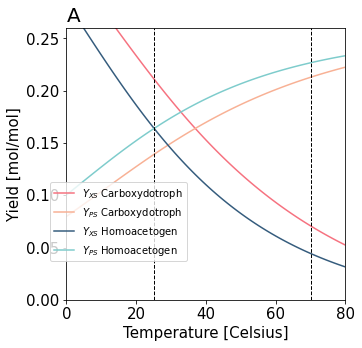

In [79]:
def Y_PS_carb(T):
    return -R_carb("Acetate",T)/R_carb("CO",T)
def Y_PS_hom(T):
    return -R_hom("Acetate",T)/R_hom("H2",T)
def Y_XS_carb(T):
    return -R_carb("X",T)/R_carb("CO",T)
def Y_XS_hom(T):
    return -R_hom("X",T)/R_hom("H2",T)

plt.figure(figsize=(5,5))
plt.title("A", fontdict = {'fontsize': 20}, loc = "left")
#plt.title(f"Yields of Acetogenesis on Electron donor")
plt.axis([0, 80, 0, 0.26])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Yield [mol/mol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Y_XS_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), Y_PS_carb(T), color='#F8B195')
plt.plot(Kelvin_Celsius(T), Y_XS_hom(T), color='#355C7D')
plt.plot(Kelvin_Celsius(T), Y_PS_hom(T), color='#7ECCCC')
plt.axvline(x = 25, color = 'black', linestyle = '--', linewidth = 1)
plt.axvline(x = 70, color = 'black', linestyle = '--', linewidth = 1)
#plt.label(bbox_to_anchor = [0.5, 0.2])
plt.legend([r'$Y_{XS}$ Carboxydotroph',r'$Y_{PS}$ Carboxydotroph',r'$Y_{XS}$ Homoacetogen',r'$Y_{PS}$ Homoacetogen'],bbox_to_anchor=(0.45, 0.45))

plt.show()

From the calculated yields, the product to biomass ratio of the arboxydotrophic and homoacetogenic reactions can be estimated, for a range of temperatures.

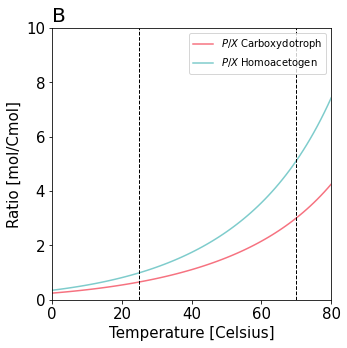

In [85]:
def Y_PX_carb(T):
    return R_actt_carb(T)/R_X(T)
def Y_PX_hom(T):
    return R_actt_hom(T)/R_X(T)

plt.figure(figsize=(5,5))
plt.title("B", fontdict = {'fontsize': 20}, loc = "left")
#plt.title(f"Product to biomass ratio in Acetogenesis")
plt.axis([0, 80, 0, 10])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Ratio [mol/Cmol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(Kelvin_Celsius(T), Y_PX_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), Y_PX_hom(T), color='#7ECCCC')
plt.axvline(x = 25, color = 'black', linestyle = '--', linewidth = 1)
plt.axvline(x = 70, color = 'black', linestyle = '--', linewidth = 1)
plt.legend([r'$P/X$ Carboxydotroph',r'$P/X$ Homoacetogen'])

plt.show()

In [86]:
T1 = Celsius_Kelvin(30)
T2 = Celsius_Kelvin(60)

print("Carboxydotrophic:")
print(f"Y_PS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PS_carb(T1),3)}, {round(Y_PS_carb(T2),3)}, change: {round(Y_PS_carb(T2)/Y_PS_carb(T1),3)}")
print(f"Y_XS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_XS_carb(T1),3)}, {round(Y_XS_carb(T2),3)}, change: {round(Y_XS_carb(T2)/Y_XS_carb(T1),3)}")
print(f"P/X at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PX_carb(T1),3)}, {round(Y_PX_carb(T2),3)}, change: {round(Y_PX_carb(T2)/Y_PX_carb(T1),3)}")

print("Homoacetogenic:")
print(f"Y_PS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PS_hom(T1),3)}, {round(Y_PS_hom(T2),3)}, change: {round(Y_PS_hom(T2)/Y_PS_hom(T1),3)}")
print(f"Y_XS at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_XS_hom(T1),3)}, {round(Y_XS_hom(T2),3)}, change: {round(Y_XS_hom(T2)/Y_XS_hom(T1),3)}")
print(f"P/X at {Kelvin_Celsius(T1)}°C and {Kelvin_Celsius(T2)}°C: {round(Y_PX_hom(T1),3)}, {round(Y_PX_hom(T2),3)}, change: {round(Y_PX_hom(T2)/Y_PX_hom(T1),3)}")

Carboxydotrophic:
Y_PS at 30.0°C and 60.0°C: 0.15, 0.201, change: 1.342
Y_XS at 30.0°C and 60.0°C: 0.191, 0.093, change: 0.488
P/X at 30.0°C and 60.0°C: 0.785, 2.158, change: 2.748
Homoacetogenic:
Y_PS at 30.0°C and 60.0°C: 0.174, 0.218, change: 1.252
Y_XS at 30.0°C and 60.0°C: 0.145, 0.061, change: 0.422
P/X at 30.0°C and 60.0°C: 1.205, 3.572, change: 2.964
